In [37]:
import os # File system operations
import re # Regular expressions
import pandas as pd # Tabular data
import numpy as np # Numerical data
pd.set_option('display.max_colwidth', None) # Show full file paths
import sys

# Don't use all of the GPU RAM
import tensorflow as tf
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
  tf.config.experimental.set_memory_growth(gpu, True)
from tensorflow.keras import mixed_precision
from tensorflow import keras # ML
import tensorflow_addons as tfa # TQDM progress bar when training
from sklearn.model_selection import train_test_split
from sklearn.utils import class_weight
from skimage import exposure

import mlflow # model runs
mlflow.set_tracking_uri("sqlite:///mlflow.db") # Use sqlite for more efficient storage
# https://www.mlflow.org/docs/latest/python_api/mlflow.tensorflow.html#mlflow.tensorflow.autolog
mlflow.tensorflow.autolog()

BATCH_SIZE = 128
EQUALIZE = False

mixed_precision.set_global_policy('mixed_float16')

from keras_tuner.tuners import RandomSearch
from keras_tuner.engine.hyperparameters import HyperParameters


from sklearn.metrics import confusion_matrix, classification_report, accuracy_score

from pathlib import Path # Pathing
from glob import glob # Finding files recursively
import matplotlib.pyplot as plt # Plotting
import seaborn as sns # Plotting
sns.set()
from tqdm.auto import tqdm # Progress bars
tqdm.pandas()

BASE_DIR = Path("EmbryoLabeling/Labelers/train")
folders = os.listdir(BASE_DIR)
folders = [f for f in folders if not re.match(r"M\d", f)]
files = []
for folder in folders:
    files_in_folder = pd.DataFrame(glob(f"{BASE_DIR}/{folder}/**/*.jpg", recursive=True), columns=["filename"])
    if len(files_in_folder) == 0:
        print(f"{folder} is empty!")
        os.rmdir(BASE_DIR / folder)
    files_in_folder["class"] = folder
    files.append(files_in_folder)
df = pd.concat(files)
df["class"].value_counts()

Compacting    2430
Blastocyst    2246
2pn           2015
Empty         1423
Syngamy       1174
2 Cell        1087
4 Cell         951
8 Cell         469
6 Cell         446
3 Cell         374
9 Cell+        244
5 Cell         215
Name: class, dtype: int64

<AxesSubplot:>

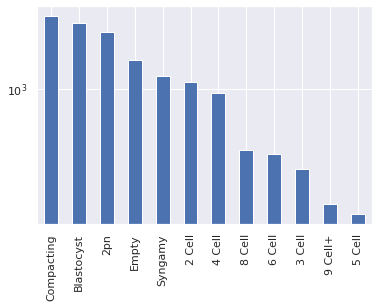

In [2]:
df["class"].value_counts().plot.bar(logy=True)

In [3]:
# Print counts of images by machine and slide
df.filename[~df["class"].isin(["bad", "Empty"])].apply(lambda s: "_".join(s.split("/")[-1].split("_")[:2])).value_counts()

M0776_S00512    1952
M776_S0087      1559
M0776_S00635    1325
M0776_S00534    1232
M3169_S00668    1166
M0776_S00761    1138
M0831_S00479     907
M0776_S00470     784
M0831_S00470     709
M0831_S00659     368
M3169_S00737     293
M0776_S00737     218
Name: filename, dtype: int64

In [4]:
# Track a single embryo's lifecycle
pd.set_option('display.max_rows', 365)
M776_S0087_W2 = df[df.filename.str.contains("M776_S0087_W2")].copy()
# Extract time since fertilisation in minutes from filename (ints, rounded to nearest minute)
M776_S0087_W2["time_since_fert"] = M776_S0087_W2.filename.apply(lambda s: s.replace(".jpg", "").split("_")[-1]).astype(int)
M776_S0087_W2 = M776_S0087_W2.sort_values(by="time_since_fert")
# Take the earliest time that each class was seen
M776_S0087_W2 = M776_S0087_W2.groupby("class").head(1)
print(M776_S0087_W2[["class", "time_since_fert"]])

           class  time_since_fert
1008         2pn             1061
983      Syngamy             1464
449       2 Cell             1574
148       3 Cell             2315
131       4 Cell             2395
11        5 Cell             3045
30        6 Cell             3125
182       8 Cell             3265
125   Compacting             3375
369   Blastocyst             6090
1198       Empty             7036


In [5]:
classes = list(M776_S0087_W2["class"])
classes

['2pn',
 'Syngamy',
 '2 Cell',
 '3 Cell',
 '4 Cell',
 '5 Cell',
 '6 Cell',
 '8 Cell',
 'Compacting',
 'Blastocyst',
 'Empty']

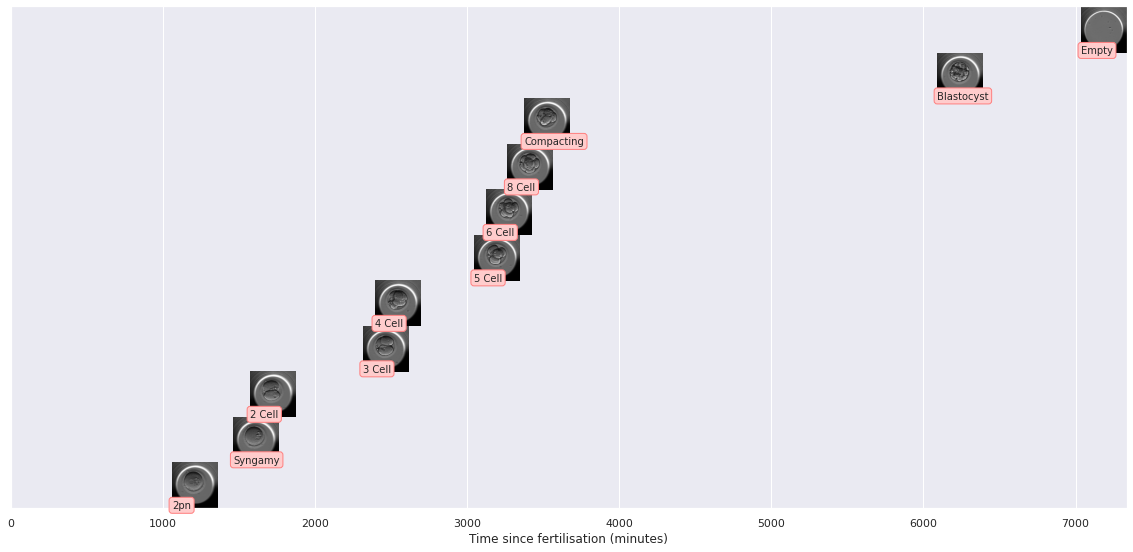

In [6]:
# Plot embryo's lifecycle over time
plt.figure(figsize=(20, 20))
for i, row in M776_S0087_W2.iterrows():
    image = keras.utils.load_img(row.filename, target_size=(299,299))
    c_index = classes.index(row["class"]) * 299
    time_since_fert = row.time_since_fert
    plt.imshow(image, extent=[time_since_fert, time_since_fert+299, c_index, c_index+299])
    plt.text(time_since_fert, c_index, row["class"], bbox=dict(boxstyle="round", ec=(1., 0.5, 0.5), fc=(1., 0.8, 0.8)))
plt.yticks([])
plt.xlabel("Time since fertilisation (minutes)")
plt.xlim(0, M776_S0087_W2.time_since_fert.max() + 300)
plt.ylim(0, len(classes) * 300)
plt.show()

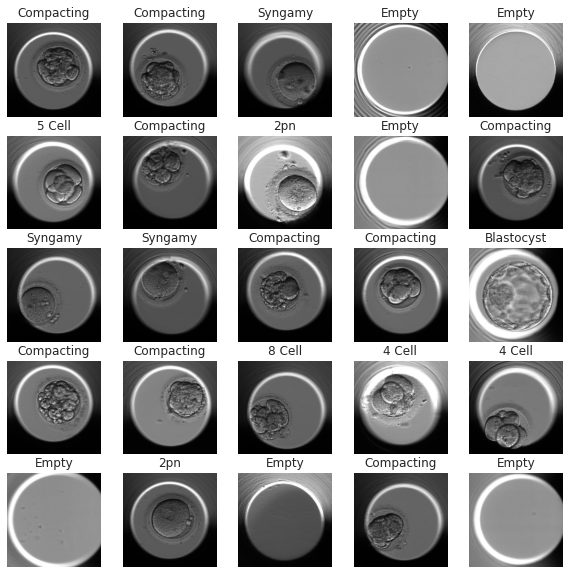

In [7]:
plt.figure(figsize=(10, 10))
sample = df.sample(25)
for i, (idx, row) in enumerate(sample.iterrows()):
    ax = plt.subplot(5, 5, i + 1)
    img = keras.utils.load_img(row.filename, target_size=(299,299))
    if EQUALIZE:
        img = tfa.image.equalize(img)
    plt.imshow(img)
    plt.title(row["class"])
    plt.axis("off")

In [8]:
train = tf.keras.utils.image_dataset_from_directory(
    BASE_DIR,
    image_size = (299,299),
    batch_size = BATCH_SIZE, #// 4, # / 4 here, because the augmentations will * 4
    label_mode = 'categorical',
    shuffle = False
)
if EQUALIZE:
    train_cache = train.map(lambda x, y: (tfa.image.equalize(x), y)).cache().prefetch(tf.data.AUTOTUNE)
else:
    train_cache = train.cache().prefetch(tf.data.AUTOTUNE)

Found 13074 files belonging to 12 classes.


2022-06-15 11:33:09.368811: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-06-15 11:33:09.369666: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-06-15 11:33:09.369887: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-06-15 11:33:09.370014: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA 

In [9]:
len(train_cache)

103

In [10]:
list(tqdm(train_cache)); # load it all into RAM

  0%|          | 0/103 [00:00<?, ?it/s]

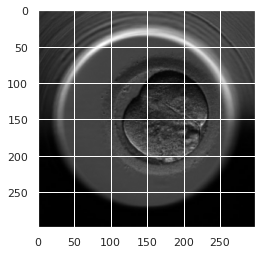

In [11]:
x, y = next(iter(train_cache))
plt.imshow(x.numpy()[0].astype("uint8"))

In [12]:
class AugmentationGenerator(tf.keras.utils.Sequence):
    def __getitem__(self, idx):
        x, y = next(iter(train_cache.skip(idx).take(1)))
        x = np.vstack([
            x,
            np.flip(x, axis=1),
            np.flip(x, axis=2),
            np.flip(np.flip(x, axis=1), axis=2),
        ])
        y = np.vstack([
            y, y, y, y
        ])
        return x, y
    def __len__(self):
        return len(train_cache)

x, y = AugmentationGenerator().__getitem__(0)
print(x.shape, y.shape)

(512, 299, 299, 3) (512, 12)


In [13]:
len(AugmentationGenerator())

103

In [14]:
classes = train.class_names
print(len(classes))
classes

12


['2 Cell',
 '2pn',
 '3 Cell',
 '4 Cell',
 '5 Cell',
 '6 Cell',
 '8 Cell',
 '9 Cell+',
 'Blastocyst',
 'Compacting',
 'Empty',
 'Syngamy']

In [15]:
base_model = keras.Sequential([
    # Pre-trained Xception weights requires that input be scaled
    # from (0, 255) to a range of (-1., +1.), the rescaling layer
    # outputs: `(inputs * scale) + offset`
    keras.layers.Rescaling(scale=1./127.5, offset=-1, input_shape=(299,299,3)),
    keras.applications.Xception(
        weights='imagenet',  # Load weights pre-trained on ImageNet.
        include_top=False,
        pooling="avg"
    )
])
base_model.save(f"models/xception.h5")
base_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 299, 299, 3)       0         
                                                                 
 xception (Functional)       (None, 2048)              20861480  
                                                                 
Total params: 20,861,480
Trainable params: 20,806,952
Non-trainable params: 54,528
_________________________________________________________________


In [16]:
cachefile = f"extracted_features{'_eq' if EQUALIZE else ''}.npy"
print(cachefile)
try:
    extracted_features = np.load(cachefile)
    assert len(extracted_features) == len(train.file_paths)*4
except Exception as e:
    print(e)
    extracted_features = base_model.predict(AugmentationGenerator())
    np.save(cachefile, extracted_features)

extracted_features.npy


In [17]:
del train_cache

In [18]:
extracted_features.shape

(52296, 2048)

In [19]:
y = np.vstack([np.vstack([y,y,y,y]) for x,y in train])
y.shape

(52296, 12)

In [20]:
aug_paths = []
for i in range(len(train)):
    batch_paths = train.file_paths[i*BATCH_SIZE:(i+1)*BATCH_SIZE]
    aug_paths.extend(batch_paths * 4)
aug_paths = pd.Series(aug_paths)
display(aug_paths)

0        EmbryoLabeling/Labelers/train/2 Cell/M0776_S00470_W2_F0_1894.jpg
1        EmbryoLabeling/Labelers/train/2 Cell/M0776_S00470_W2_F0_1914.jpg
2        EmbryoLabeling/Labelers/train/2 Cell/M0776_S00470_W2_F0_1934.jpg
3        EmbryoLabeling/Labelers/train/2 Cell/M0776_S00470_W2_F0_1954.jpg
4        EmbryoLabeling/Labelers/train/2 Cell/M0776_S00470_W2_F0_1974.jpg
                                       ...                               
52291     EmbryoLabeling/Labelers/train/Syngamy/M776_S0087_W5_F0_1555.jpg
52292     EmbryoLabeling/Labelers/train/Syngamy/M776_S0087_W5_F0_1585.jpg
52293     EmbryoLabeling/Labelers/train/Syngamy/M776_S0087_W5_F0_1605.jpg
52294     EmbryoLabeling/Labelers/train/Syngamy/M776_S0087_W5_F0_1625.jpg
52295     EmbryoLabeling/Labelers/train/Syngamy/M776_S0087_W5_F0_1645.jpg
Length: 52296, dtype: object

In [21]:
fert_minutes = aug_paths.apply(lambda s: s.replace(".jpg", "").split("_")[-1]).astype(int)
fert_minutes

0        1894
1        1914
2        1934
3        1954
4        1974
         ... 
52291    1555
52292    1585
52293    1605
52294    1625
52295    1645
Length: 52296, dtype: int64

In [22]:
extracted_features_with_fert = np.hstack([extracted_features, fert_minutes.to_numpy()[:, None]])
extracted_features_with_fert.shape

(52296, 2049)

In [23]:
#x_train, x_test, y_train, y_test = train_test_split(extracted_features, y, test_size=.2)

# Use one slide for test, everything else for train
test_slide = "M0831"
test_idx = aug_paths.str.contains(test_slide)
x_train = extracted_features_with_fert[~test_idx]
y_train = y[~test_idx]
x_test = extracted_features_with_fert[test_idx]
y_test = y[test_idx]
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((42816, 2049), (42816, 12), (9480, 2049), (9480, 12))

In [24]:
class_weights = class_weight.compute_class_weight('balanced', classes = np.unique(y.argmax(axis=1)), y=y.argmax(axis=1))
class_weights = class_weights.round(6) # This is necessary if using mlflow, as it can go beyond the 250 character limit otherwise
class_weights = dict(enumerate(class_weights))
{k:v for k,v in zip(classes, class_weights.values())}

{'2 Cell': 1.0023,
 '2pn': 0.540695,
 '3 Cell': 2.913102,
 '4 Cell': 1.145636,
 '5 Cell': 5.067442,
 '6 Cell': 2.442825,
 '8 Cell': 2.323028,
 '9 Cell+': 4.465164,
 'Blastocyst': 0.485085,
 'Compacting': 0.448354,
 'Empty': 0.765636,
 'Syngamy': 0.928024}

In [25]:
# Hyperparameter search
search = False
if search:
    def build_model(hp):
        model = keras.Sequential()
        model.add(keras.layers.Input(shape=(x_train.shape[1])))

        for i in range(hp.Int("n_layers", 1, 4)):
            model.add(keras.layers.Dense(
                hp.Int(f"dense_units_{i}", min_value=32, max_value=128, step=32),
                activation=hp.Choice(f"dense_activation_{i}", values=["relu", "sigmoid"], default="relu")
            ))
            model.add(keras.layers.Dropout(hp.Float(f"dropout_{i}", min_value=.1, max_value=.5, step=.1)))

        model.add(keras.layers.Dense(len(classes), activation="softmax"))
        model.compile(
            optimizer=keras.optimizers.Adam(learning_rate=hp.Float(
                "learning_rate", min_value=1e-4, max_value=1e-2, sampling="LOG", default=1e-3
            )),
            loss=keras.losses.CategoricalCrossentropy(),
            metrics=[keras.metrics.CategoricalAccuracy()],
        )
        return model

    tuner = RandomSearch(
        build_model,
        objective="val_categorical_accuracy",
        max_trials=80,
    )
    tuner.search_space_summary()
    tuner.search(
        x_train,
        y_train,
        batch_size=BATCH_SIZE,
        validation_data=(x_test, y_test),
        epochs=500,
        verbose=0,
        class_weight=class_weights,
        callbacks=[
            keras.callbacks.EarlyStopping(monitor='val_categorical_accuracy',patience=50, verbose=1),
            tfa.callbacks.TQDMProgressBar()
        ]
    )
    print(tuner.get_best_hyperparameters()[0].values)
    print(tuner.get_best_models()[0].summary())

In [26]:
%%time
with mlflow.start_run():
    mlflow.log_params({
        "classes": classes,
        "equalized": EQUALIZE,
        "test slide": test_slide,
        "x_train_shape": x_train.shape,
        "y_train_shape": y_train.shape,
        "x_test_shape": x_test.shape,
        "y_test_shape": y_test.shape
    })

    model = keras.Sequential([
        keras.layers.Input(shape=(x_train.shape[1])),
        keras.layers.Dense(512, activation="relu"),
        keras.layers.Dense(512, activation="relu"),
        keras.layers.Dense(len(classes), activation="softmax")
    ])
    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=keras.optimizers.schedules.ExponentialDecay(
            .001,
            decay_steps=1e4,
            decay_rate=0.96,
            staircase=True
        )),
        loss=keras.losses.CategoricalCrossentropy(),
        metrics=[keras.metrics.CategoricalAccuracy()],
    )
    print(model.summary())
    history = model.fit(x_train,
                        y_train,
                        batch_size=BATCH_SIZE,
                        validation_data=(x_test, y_test),
                        epochs=500,
                        verbose=0,
                        class_weight=class_weights,
                        callbacks=[
                            keras.callbacks.EarlyStopping(monitor='val_categorical_accuracy',patience=50, verbose=1),
                            tfa.callbacks.TQDMProgressBar()
                        ])

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 512)               1049600   
                                                                 
 dense_1 (Dense)             (None, 512)               262656    
                                                                 
 dense_2 (Dense)             (None, 12)                6156      
                                                                 
Total params: 1,318,412
Trainable params: 1,318,412
Non-trainable params: 0
_________________________________________________________________
None


Training:   0%|           0/500 ETA: ?s,  ?epochs/s

Epoch 1/500


0/335           ETA: ?s - 

Epoch 2/500


0/335           ETA: ?s - 

Epoch 3/500


0/335           ETA: ?s - 

Epoch 4/500


0/335           ETA: ?s - 

Epoch 5/500


0/335           ETA: ?s - 

Epoch 6/500


0/335           ETA: ?s - 

Epoch 7/500


0/335           ETA: ?s - 

Epoch 8/500


0/335           ETA: ?s - 

Epoch 9/500


0/335           ETA: ?s - 

Epoch 10/500


0/335           ETA: ?s - 

Epoch 11/500


0/335           ETA: ?s - 

Epoch 12/500


0/335           ETA: ?s - 

Epoch 13/500


0/335           ETA: ?s - 

Epoch 14/500


0/335           ETA: ?s - 

Epoch 15/500


0/335           ETA: ?s - 

Epoch 16/500


0/335           ETA: ?s - 

Epoch 17/500


0/335           ETA: ?s - 

Epoch 18/500


0/335           ETA: ?s - 

Epoch 19/500


0/335           ETA: ?s - 

Epoch 20/500


0/335           ETA: ?s - 

Epoch 21/500


0/335           ETA: ?s - 

Epoch 22/500


0/335           ETA: ?s - 

Epoch 23/500


0/335           ETA: ?s - 

Epoch 24/500


0/335           ETA: ?s - 

Epoch 25/500


0/335           ETA: ?s - 

Epoch 26/500


0/335           ETA: ?s - 

Epoch 27/500


0/335           ETA: ?s - 

Epoch 28/500


0/335           ETA: ?s - 

Epoch 29/500


0/335           ETA: ?s - 

Epoch 30/500


0/335           ETA: ?s - 

Epoch 31/500


0/335           ETA: ?s - 

Epoch 32/500


0/335           ETA: ?s - 

Epoch 33/500


0/335           ETA: ?s - 

Epoch 34/500


0/335           ETA: ?s - 

Epoch 35/500


0/335           ETA: ?s - 

Epoch 36/500


0/335           ETA: ?s - 

Epoch 37/500


0/335           ETA: ?s - 

Epoch 38/500


0/335           ETA: ?s - 

Epoch 39/500


0/335           ETA: ?s - 

Epoch 40/500


0/335           ETA: ?s - 

Epoch 41/500


0/335           ETA: ?s - 

Epoch 42/500


0/335           ETA: ?s - 

Epoch 43/500


0/335           ETA: ?s - 

Epoch 44/500


0/335           ETA: ?s - 

Epoch 45/500


0/335           ETA: ?s - 

Epoch 46/500


0/335           ETA: ?s - 

Epoch 47/500


0/335           ETA: ?s - 

Epoch 48/500


0/335           ETA: ?s - 

Epoch 49/500


0/335           ETA: ?s - 

Epoch 50/500


0/335           ETA: ?s - 

Epoch 51/500


0/335           ETA: ?s - 

Epoch 52/500


0/335           ETA: ?s - 

Epoch 53/500


0/335           ETA: ?s - 

Epoch 54/500


0/335           ETA: ?s - 

Epoch 55/500


0/335           ETA: ?s - 

Epoch 56/500


0/335           ETA: ?s - 

Epoch 57/500


0/335           ETA: ?s - 

Epoch 58/500


0/335           ETA: ?s - 

Epoch 58: early stopping
INFO:tensorflow:Assets written to: /tmp/tmpl61wyyow/model/data/model/assets
CPU times: user 3min 5s, sys: 32.8 s, total: 3min 38s
Wall time: 2min 29s


In [27]:
model.save(f"models/{len(classes)}_class.h5")

In [28]:
pd.Series(classes).to_csv(f"models/{len(classes)}_class.h5_classes.txt", index=False, header=False)

<AxesSubplot:>

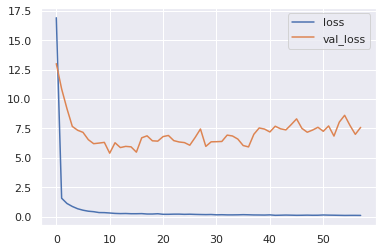

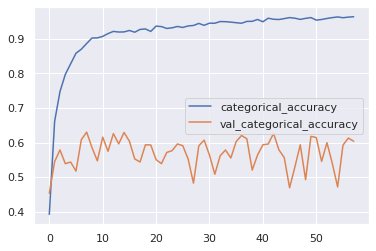

In [38]:
history_df = pd.DataFrame(history.history)
history_df[['loss', 'val_loss']].plot()
history_df[['categorical_accuracy', 'val_categorical_accuracy']].plot()

In [39]:
y_pred = model.predict(x_test)

297/297 [==============================] - 1s 2ms/step


In [63]:
validation_df = pd.DataFrame()
validation_df["filepaths"] = aug_paths[test_idx].to_list()
validation_df["true"] = y_test.argmax(axis=1)
aug_true = validation_df.groupby("filepaths").head(1)["true"]
display(aug_true)
aug_pred = pd.concat([validation_df, pd.DataFrame(y_pred, columns=classes)], axis="columns").groupby(
    "filepaths").sum().to_numpy() / 4
aug_pred

0        0
1        0
2        0
3        0
4        0
        ..
9355    11
9356    11
9357    11
9358    11
9359    11
Name: true, Length: 2370, dtype: int64

array([[0.00000000e+00, 3.79638672e-01, 7.22408295e-05, ...,
        4.47034836e-08, 4.17232513e-07, 1.98185444e-05],
       [0.00000000e+00, 2.34497070e-01, 1.26481056e-04, ...,
        2.98023224e-08, 1.93715096e-07, 1.20580196e-04],
       [0.00000000e+00, 7.35839844e-01, 1.17182732e-04, ...,
        1.49011612e-08, 8.94069672e-08, 1.72138214e-04],
       ...,
       [1.10000000e+01, 2.44750977e-01, 1.94702148e-01, ...,
        1.49011612e-08, 3.72529030e-07, 5.60546875e-01],
       [1.10000000e+01, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 1.00000000e+00],
       [1.10000000e+01, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 1.00000000e+00]])

In [57]:
predicted_codes = aug_pred.argmax(axis=1)
confidence = aug_pred.max(axis=1)
pd.Series(confidence).describe()

count    2370.000000
mean        0.839844
std         0.190430
min         0.260010
25%         0.689087
50%         0.948486
75%         0.999023
max         1.000000
dtype: float64

In [65]:
validation_df = pd.DataFrame()
validation_df["true_class"] = aug_true
validation_df["predicted_class"] = predicted_codes
validation_df["confidence"] = confidence
validation_df

,true_class,predicted_class,confidence
0,0,2,0.617188
1,0,2,0.760742
2,0,0,0.735840
3,0,0,0.572754
4,0,3,0.749023
...,...,...,...
9355,11,11,0.741699
9356,11,11,0.647461
9357,11,11,0.560547
9358,11,11,1.000000


In [66]:
validation_df.groupby("predicted_class").confidence.median()

predicted_class
0     0.912109
1     0.999512
2     0.698242
3     0.565918
4     0.545410
5     0.495605
6     0.654297
8     0.997070
9     0.833984
10    0.987305
11    1.000000
Name: confidence, dtype: float16

In [67]:
validation_df.to_csv("validation_predictions.csv", index=False)

              precision    recall  f1-score   support

           0       0.58      0.70      0.64       131
           1       0.74      0.92      0.82       394
           2       0.03      0.03      0.03        58
           3       0.35      0.43      0.39       159
           4       0.11      0.02      0.04        85
           5       0.16      0.07      0.10        86
           6       0.08      0.12      0.10        85
           7       0.00      0.00      0.00       244
           8       0.71      0.96      0.81       257
           9       0.44      0.84      0.58       238
          10       1.00      0.94      0.97       386
          11       0.93      0.50      0.65       247

    accuracy                           0.62      2370
   macro avg       0.43      0.46      0.43      2370
weighted avg       0.57      0.62      0.58      2370

[ 0.   0.   0.   0.   0.   0.   0.   3.1 14.4 32.2]


/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Text(66.5, 0.5, 'True')

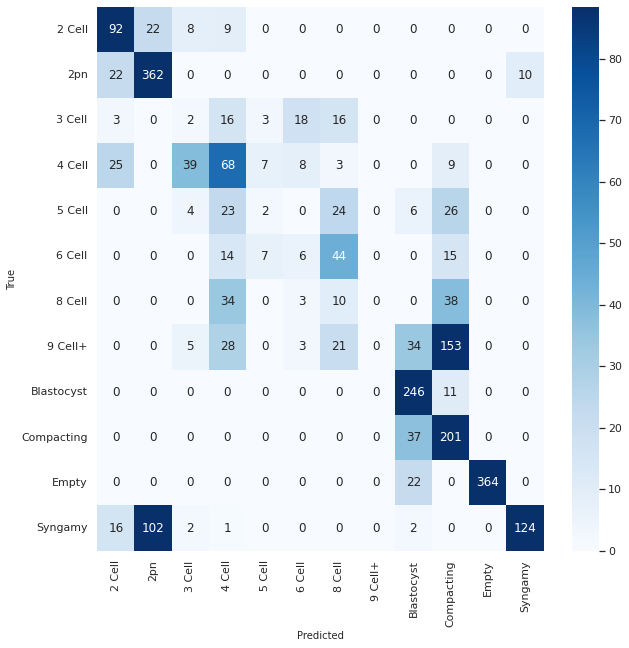

In [68]:
print(classification_report(validation_df["true_class"], validation_df["predicted_class"]))
confusion = confusion_matrix(validation_df["true_class"], validation_df["predicted_class"])
print(np.quantile(confusion, np.arange(0, 1, .1)))
plt.figure(figsize=(10,10))
s = sns.heatmap(
    confusion,
    annot=True,
    cmap='Blues',
    fmt="g",
    xticklabels=classes,
    yticklabels=classes,
    vmax=np.quantile(confusion, .95)
)
s.set_xlabel('Predicted', fontsize=10)
s.set_ylabel('True', fontsize=10)